In [1]:
# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload
# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

# Tutorial 

## Aim

Implementation to compute and analyse the R-factor of the RUSLE-equation. The
R-factor is a measure for the total erosivity of a number of rainfall events
within a defined timeframe (year, month, number of days). The factor is
computed by calculating the yearly sum of -for every rainfall event- the sum
of the depth of rainfall (mm) and the kinetic energy, and taking the mean
over all years.

---
__NOTE__

This notebook does not include the erosivity computation based on the Royal Meteorological Institute of Belgium (RMI) rainfall data, as the data is not available as open data. One can contact RMI to obtain the rainfall input data. Alternatively, the results of the computation of the erosivity values based on the RMI data are provided in this notebook as well as other rainfall input data, so one can proceed with the analysis.

---

## Package imports

In [7]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Load the `rfactor` package functionalities

In [8]:
from rfactor import compute_erosivity, maximum_intensity, maximum_intensity_matlab_clone
from rfactor.process import load_rain_folder, compute_rainfall_statistics, get_rfactor_station_year

## Input data and compute erosivity

__Set folders__

The main function `compute_erosivity` requires a [pandas DataFrame](https://pandas.pydata.org/docs/index.html) containing __non-zero__ rainfall data with the following columns:

- datetime (pd.Timestamp): Time stamp
- rain_mm (float): Rain in mm
- station (str): Measurement station identifier

However, the legacy format of the input files used in the original Matlab implementation is still supported as well. For this format, te input files are defined by text files (extension: `txt`) that hold __non-zero rainfall__ timeseries. The data are split per station and per year with a specific data file tag `STATION_YYYY`:  

```
KMI_6414_2004.txt  
KMI_6414_2005.txt  
...  
KMI_6434_2003.txt  
KMI_6434_2004.txt  
...  
```

__Note__: the files in `tests/data/test_rainfalldata` are an incomplete data set for Belgium (RMI rainfall data are not included), an alternative is provided in the section 'Analysis'. 

In [11]:
fmap_rainfall =  Path(r"../../tests/data/test_rainfalldata")
fmap_erosivity = Path(r"../../tests/data/test_erosivitydata")

Use the `load_rain_folder` function to read all rain data in a folder:

In [12]:
all_rainfall = load_rain_folder(fmap_rainfall)

100%|██████████| 581/581 [00:04<00:00, 133.85it/s]


**Compute rainfall statistics** (and add station metadata)

In [15]:
stations = pd.read_csv("data/belgium/stations.csv")

rain_stats = compute_rainfall_statistics(all_rainfall, stations)
rain_stats.head()

,year,station,x,y,records,min,median,max
0,[2018],P01_001,NaN,NaN,2718,0.01,0.09,5.05
1,"[2005, 2006, 2007, 2008, 2009, 2010, 2011, 201...",P01_003,51907.0,191193.0,56546,0.01,0.10,24.32
2,"[2005, 2006, 2007, 2008, 2009, 2010, 2011, 201...",P01_010,45836.0,171260.0,54543,0.01,0.10,22.75
3,"[2005, 2006, 2007, 2008, 2009, 2010, 2011, 201...",P01_015,37391.0,203053.0,52304,0.01,0.10,21.61
4,"[2009, 2010, 2011, 2012, 2013, 2014, 2015, 201...",P01_029,25566.0,198775.0,36628,0.01,0.12,15.75


**Select stations to compute erosivity for**

In [18]:
consider_stations = pd.read_csv("../../tests/data/files_tests.csv")

sel_rainfall = all_rainfall.loc[all_rainfall["tag"].isin(consider_stations["datafile"])]

In [19]:
sel_rainfall

,minutes_since,rain_mm,datetime,station,year,tag
0,130,0.27,2018-01-01 02:10:00,P01_001,2018,P01_001_2018
1,140,0.02,2018-01-01 02:20:00,P01_001,2018,P01_001_2018
2,190,0.48,2018-01-01 03:10:00,P01_001,2018,P01_001_2018
3,460,0.22,2018-01-01 07:40:00,P01_001,2018,P01_001_2018
4,470,0.09,2018-01-01 07:50:00,P01_001,2018,P01_001_2018
...,...,...,...,...,...,...
1979660,526990,0.11,2012-12-31 23:10:00,P11_043,2012,P11_043_2012
1979661,527000,0.16,2012-12-31 23:20:00,P11_043,2012,P11_043_2012
1979662,527010,0.11,2012-12-31 23:30:00,P11_043,2012,P11_043_2012
1979663,527020,0.09,2012-12-31 23:40:00,P11_043,2012,P11_043_2012


**Run Model**  

By default, the erosivity is calculated with the `maximum_intensity` method implemented in Python, which follows a slightly different approach to the original Matlab implementation. However, one can opt to use the `matlab_clone` method as well, which is a Python implementation mimicking the original one:

In [20]:
erosivity = compute_erosivity(sel_rainfall, maximum_intensity_matlab_clone)

## Analysis (in Dutch)

If one does not have acces to the RMI data, the output erosivity from the computation with the full data set is provided in this repository as an alternative:

In [100]:
erosivity = pd.read_csv("data/erosivity_belgium.csv", parse_dates=[0, 1], index_col=0)

**Ukkel**  

Compute R-factor for specific periods for Ukkel (KMI_6447 and KMI_F3).

In [101]:
timeseries = [range(1898,2003,1),
              range(2003,2021,1),
              range(1898,2021,1),
              range(1996,2021,1),
              range(1991,2021,1),
              range(1990,2001,1),
              range(2000,2021,1)]

for period in timeseries:
    rfactor = get_rfactor_station_year(erosivity,["KMI_6447","KMI_FS3"], period)
    print(f"R-factor for period from {period[0]} till {period[-1]} is: {rfactor['erosivity_cum'].mean()}")

R-factor for period from 1898 till 2002 is: 1013.4479797035281
R-factor for period from 2003 till 2020 is: 1336.397628211325
R-factor for period from 1898 till 2020 is: 1060.708903875401
R-factor for period from 1996 till 2020 is: 1296.9830530121917
R-factor for period from 1991 till 2020 is: 1288.9563623716533
R-factor for period from 1990 till 2000 is: 1125.5684373036177
R-factor for period from 2000 till 2020 is: 1331.8310591237398


**Make figure for Ukkel**

In [102]:
rfactor_all["erosivity_cum"].rolling(window).mean()

18            NaN
19            NaN
20            NaN
21            NaN
22            NaN
         ...     
13    1269.548959
14    1273.962994
15    1282.485828
16    1296.664085
17    1288.956362
Name: erosivity_cum, Length: 123, dtype: float64

In [103]:
get_rfactor_station_year(erosivity, stations=["KMI_FS3", "KMI_6447"]).sort_values("year")

,year,station,erosivity_cum
18,1898,KMI_FS3,636.713476
19,1899,KMI_FS3,1324.678836
20,1900,KMI_FS3,776.940190
21,1901,KMI_FS3,903.894007
22,1902,KMI_FS3,1359.325004
...,...,...,...
13,2016,KMI_6447,1315.742501
14,2017,KMI_6447,807.361064
15,2018,KMI_6447,1509.934425
16,2019,KMI_6447,844.407555


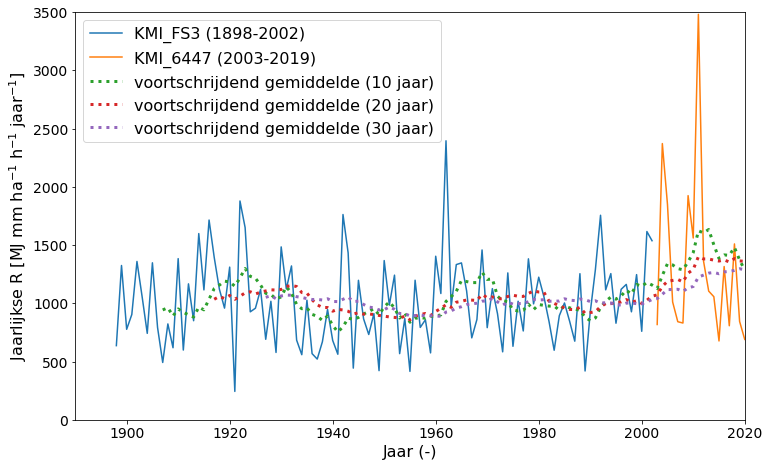

In [104]:
fig, ax = plt.subplots(figsize=(12, 7.5))

rfactor_fs3 = get_rfactor_station_year(erosivity, ["KMI_FS3"])
rfactor_fs3 = rfactor_fs3[~(rfactor_fs3["erosivity_cum"].isnull())].sort_values("year")
ax.plot(rfactor_fs3["year"], rfactor_fs3["erosivity_cum"], label="KMI_FS3 (1898-2002)")

rfactor_6447 = get_rfactor_station_year(erosivity, ["KMI_6447"])
rfactor_6447 = rfactor_6447[~(rfactor_6447["erosivity_cum"].isnull())].sort_values("year")
ax.plot(rfactor_6447["year"], rfactor_6447["erosivity_cum"], label="KMI_6447 (2003-2019)")

# rolling mean
rfactor_all = get_rfactor_station_year(erosivity, stations=["KMI_FS3", "KMI_6447"]).sort_values("year")
windows  = [10, 20, 30]
for window in windows:
    y = rfactor_all.rolling(window)["erosivity_cum"].mean()
    ax.plot(rfactor_all["year"], y, ls=':', lw=3, 
            label=f"voortschrijdend gemiddelde ({window} jaar)")
    

ax.set_ylim([0,3500])
ax.set_xlim([1890,2020])
ax.tick_params(axis='both', which='major', labelsize=14)
ax.set_xlabel(r'Jaar (-)',fontsize=16)
ax.set_ylabel(r'Jaarlijkse R [MJ mm ha$^{-1}$ h$^{-1}$ jaar$^{-1}$]',fontsize=16)
ax.legend(prop={'size':16})

**All stations expect Ukkel**

In [105]:
stations_belgium_excl_ukkel = [station for station in stations["station"] 
                               if station not in ["KMI_6447","KMI_FS3", "KMI1990_2002", "KMI2003_nu_v2"]]
years = range(1898, 2021, 1)
years = [year for year in years if year in 
         erosivity[erosivity["station"].isin(stations_belgium_excl_ukkel)]["year"].unique()]

rfactor_non_ukkel = get_rfactor_station_year(erosivity, 
                                             stations=stations_belgium_excl_ukkel, 
                                             years=years)
print(rfactor_non_ukkel["erosivity_cum"].mean())
len(rfactor_non_ukkel["station"].unique())

1257.379735478444


55

**All stations flanders**

In [106]:
stations_flanders = [station for station in stations["station"] 
                     if station not in  ["KMI_6447", "KMI_FS3", "KMI_6455", "KMI_6459",
                                         "KMI_6472", "KMI_6494", "KMI_6484", "KMI1990_2002", "KMI2003_nu_v2"]]
years = range(1898, 2021, 1)
years = [year for year in years if year in 
         erosivity[erosivity["station"].isin(stations_flanders)]["year"].unique()]

rfactor_flanders = get_rfactor_station_year(erosivity,stations_flanders, years)
print(rfactor_flanders["erosivity_cum"].mean())
len(rfactor_flanders["station"].unique())

1237.3075804931602


50

**Plot the distribution of all R-values for Belgium, excluding the data from Ukkel**

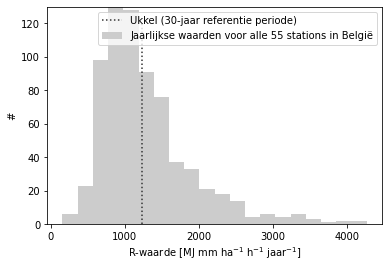

In [107]:
years = [year for year in range(1991, 2021) if year in 
         erosivity[erosivity["station"].isin(stations_belgium_excl_ukkel)]["year"].unique()]

rfactor_non_ukkel = get_rfactor_station_year(erosivity, stations_belgium_excl_ukkel, years)

fig, ax = plt.subplots()
ax.hist(rfactor_non_ukkel["erosivity_cum"], bins=20, color=[0.8]*3,
        label=r"Jaarlijkse waarden voor alle 55 stations in België")
ax.plot([1239, 1239], [0, 120], color=[0.2]*3, ls=":", label="Ukkel (30-jaar referentie periode)")
ax.set_ylabel(r"#")
ax.set_xlabel(r"R-waarde [MJ mm ha$^{-1}$ h$^{-1}$ jaar$^{-1}$]")
ax.set_ylim([0,130])
ax.legend()

**All stations of the VMM (Flanders)**

In [108]:
erosivity

,datetime.1,event_rain_cum,max_30min_intensity,event_energy,erosivity,all_event_rain_cum,erosivity_cum,station,year,tag
datetime,,,,,,,,,,
2004-01-07 12:30:00,2004-01-07 12:30:00,7.40,10.60,1.642414,17.409589,0.00,17.409589,KMI_6414,2004,KMI_6414_2004
2004-01-08 11:30:00,2004-01-08 11:30:00,5.90,4.80,0.977963,4.694222,7.40,22.103810,KMI_6414,2004,KMI_6414_2004
2004-01-11 05:40:00,2004-01-11 05:40:00,8.10,4.80,1.242868,5.965767,14.50,28.069577,KMI_6414,2004,KMI_6414_2004
2004-01-11 19:30:00,2004-01-11 19:30:00,7.10,9.60,1.611688,15.472204,22.60,43.541781,KMI_6414,2004,KMI_6414_2004
2004-01-12 08:40:00,2004-01-12 08:40:00,21.40,9.60,3.684080,35.367172,29.70,78.908954,KMI_6414,2004,KMI_6414_2004
...,...,...,...,...,...,...,...,...,...,...
2020-12-14 18:50:00,2020-12-14 18:50:00,6.11,1.42,0.636761,0.904201,584.59,785.585714,P11_043,2020,P11_043_2020
2020-12-21 10:20:00,2020-12-21 10:20:00,6.42,2.04,0.737794,1.505099,591.69,787.090813,P11_043,2020,P11_043_2020
2020-12-22 15:30:00,2020-12-22 15:30:00,16.38,3.86,2.317770,8.946592,598.11,796.037405,P11_043,2020,P11_043_2020


In [113]:
stations_vmm = [station for station in stations["station"] if "KMI" not in station]

rfactor_vmm = get_rfactor_station_year(erosivity, stations_vmm)

print(rfactor_vmm["erosivity_cum"].mean())
len(rfactor_vmm["station"].unique())

1237.077014785147


43

**Compute values per year over all stations**

In [120]:
(get_rfactor_station_year(erosivity)
 .groupby("station")
 .aggregate(
    {"erosivity_cum":[np.mean, np.std],
     "year": "count"})
 .sort_values(('year', 'count'), ascending=False)
 .reset_index()
)

station erosivity_cum               year
                      mean          std count
0    KMI_FS3   1013.447980   372.030461   105
1   KMI_6459   1342.419073   585.411025    20
2   KMI_6455   1203.791757   578.286308    20
3   KMI_6434   1395.650915   505.788697    18
4   KMI_6472   1283.746950   664.442273    18
5   KMI_6447   1336.397628   717.022599    18
6   KMI_6484   1447.547987   410.672521    17
7   KMI_6414   1351.436871   657.902434    17
8    P11_007   1293.762120   498.526282    16
9    P08_009   1312.770803   784.515398    16
10   P09_016   1277.558439   605.450071    16
11   P03_017   1492.972795   641.917534    16
12   P03_005   1282.562029   415.816142    16
13   P08_018   1377.282162   796.665508    16
14   P02_008   1107.936325   413.800105    16
15   P02_004   1378.959393   909.600748    16
16   P08_013   1189.783684   545.068058    16
17   P01_015   1090.112730   437.259380    16
18   P01_010   1449.691160   622.033426    16
19   P01_003   1418.290092   767.219120    16
20   P07_006   1044.724301   409.969541    16
21   P09_012   1152.069795   484.212211    16
22   P06_014   1071.548622   278.587932    15
23   P10_011   1150.559920   413.434757    15
24   P11_002   1277.225780   718.007959    15
25  KMI_6477   1345.682044   658.148797    15
26   P05_019    834.893640   187.452290    14
27   P07_021   1024.883579   567.140448    14
28   P07_022   1290.671931   447.699099    14
29   P11_024   1448.570922  1059.335762    14
30   P04_020   1155.457860   585.477272    13
31   P04_001   1537.649048   485.756724    13
32  KMI_6439   1169.529461   480.978707    13
33   P08_031   1198.694291   611.355465    12
34   P08_028   1137.982185   728.176289    12
35   P09_025   1142.020684   533.306992    12
36   P09_032   1399.275294   850.543054    12
37   P09_026   1102.756760   559.757068    12
38   P04_027   1210.151071   425.203837    12
39   P06_040   1083.610845   320.083690    12
40   P03_041   1066.256349   364.446664    12
41   P01_029   1332.382381   996.246264    12
42   P05_039   1362.462917   670.997759    12
43   P03_036   1462.484563   844.271765    12
44   P01_037    886.616101   279.273285    12
45   P11_043   1388.573908   868.620922    12
46   P08_033   1423.522459   620.629392    11
47   P09_034   1157.774954   462.258067    11
48   P09_035   1670.461762   945.339789    11
49   P08_023   1040.904464   454.344420    10
50   P10_042   1237.331122   565.793083    10
51   P02_030   1077.718705   323.032167     9
52   P05_038    968.648040   238.527416     9
53  KMI_6418    823.844453   377.651136     8
54  KMI_6494   2378.797416   812.871388     8
55  KMI_6464   1121.448030   584.265294     8
56  KMI_6431   1042.802421   271.880632     6
57   P04__01   1050.077755   645.674255     2
58   P01_001    410.447246          NaN     1

## Analysis (monthly resolution, in Dutch)
Get the EI30-values for 2018 based on two Ukkel station ("KMI_6447","KMI_FS3")  

In [126]:
erosivity.loc[erosivity["station"].isin(["KMI_6447", "KMI_FS3"]), "erosivity"]

datetime
2003-01-01 09:50:00    14.547072
2003-01-02 17:40:00     6.867493
2003-01-03 13:20:00     1.538409
2003-01-15 19:10:00     2.533816
2003-01-20 14:40:00     1.847034
                         ...    
2002-12-22 00:20:00     8.246841
2002-12-26 06:40:00     6.089722
2002-12-27 00:50:00     1.762922
2002-12-28 09:30:00     0.263500
2002-12-29 08:10:00    44.660217
Name: erosivity, Length: 13729, dtype: float64

In [127]:
erosivity_monthly = (erosivity.loc[erosivity["station"].isin(["KMI_6447", "KMI_FS3"]), "erosivity"]
                     .resample("M")
                     .sum()
                     .to_frame())

In [128]:
erosivity_monthly["month"] = erosivity_monthly.index.month

In [131]:
from functools import partial

In [135]:
tt = partial(np.percentile, 25)

In [136]:
np.percentile()

array([25., 25., 25., 25.])

In [140]:
em = (erosivity_monthly
      .groupby("month")
      .aggregate({
          "erosivity":[np.mean, 
                       lambda x: np.percentile(x, 25), 
                       lambda x: np.percentile(x,75)]
      }))

In [142]:
em["mean"] = em["erosivity"]["mean"]
em["l_e"] = em["erosivity"]["mean"] - em["erosivity"]["<lambda_0>"]
em["u_e"] = em["erosivity"]["<lambda_1>"] - em["erosivity"]["mean"]

In [143]:
em

erosivity                               mean         l_e        u_e
             mean <lambda_0>  <lambda_1>                                   
month                                                                      
1       39.133796  16.920618   53.336438   39.133796   22.213177  14.202642
2       27.215990  10.029274   37.923135   27.215990   17.186715  10.707145
3       33.509429  14.385286   46.768732   33.509429   19.124143  13.259303
4       37.799479  17.213917   46.102335   37.799479   20.585562   8.302856
5       96.224409  29.477947  112.743560   96.224409   66.746461  16.519151
6      130.780288  37.011502  189.230319  130.780288   93.768787  58.450031
7      247.616610  64.505239  328.531664  247.616610  183.111371  80.915053
8      176.892645  58.274647  220.621763  176.892645  118.617998  43.729118
9      105.283020  33.473290  126.007565  105.283020   71.809731  20.724544
10      73.353482  25.118608   84.890759   73.353482   48.234874  11.537276
11      49.241269  21.334247   62.153328   49.241269   27.907022  12.912059
12      43.658486  20.036902   60.874211   43.658486   23.621584  17.215725

**Plot**

Text(0, 0.5, 'R-waarde [MJ mm ha$^{-1}$ h$^{-1}$ maand$^{-1}$]')

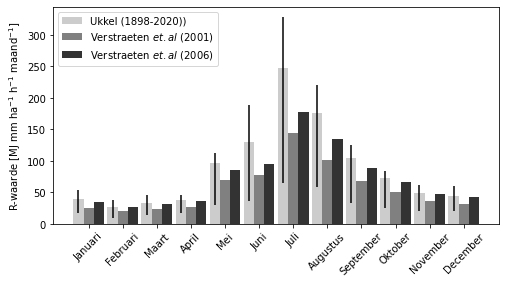

In [144]:
fig = plt.figure(figsize=(8, 4))

x = np.arange(len(em))
y_gv = [26, 20, 24, 27, 70, 77, 144, 102, 68, 50, 37, 32]
y_gv2 = [35, 27, 32, 36, 86, 96, 177, 135, 89, 66, 48, 43]
plt.bar(x-0.3,em["mean"],yerr=em[["l_e","u_e"]].T.values,color=[0.80]*3,width=0.3,label="Ukkel (1898-2020))")
plt.bar(x,y_gv,width=0.3,color=[0.5]*3,label="Verstraeten $\it{et. al}$ (2001)")
plt.bar(x+0.3,y_gv2,width=0.3,color=[0.2]*3,label="Verstraeten $\it{et. al}$ (2006)")
plt.ylabel("R-value")
ax = fig.axes
plt.xticks(x,["Januari","Februari","Maart","April","Mei","Juni","Juli","Augustus","September","Oktober","November","December"],rotation=45)
plt.legend(loc=2,facecolor ="white")
plt.ylabel(r"R-waarde [MJ mm ha$^{-1}$ h$^{-1}$ maand$^{-1}$]")

## Additional: monthly analysis (detail)
**Evolution monthly R-value**
Generate plot to analyse evolution of montly R over the years

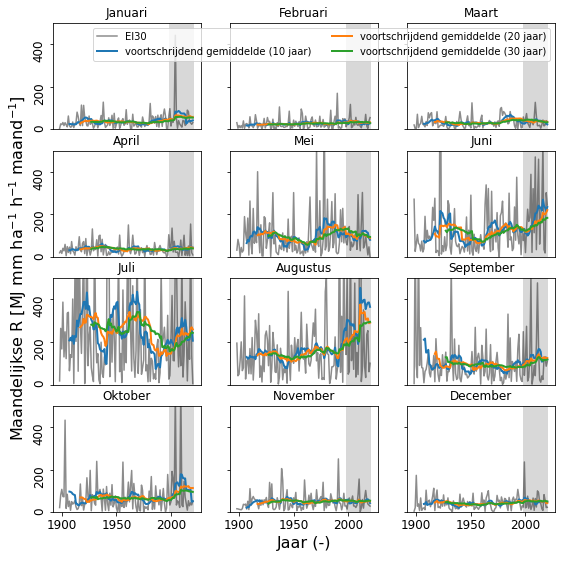

In [145]:
def subplot_montlhy_R(df,ax,ind1,ind2):
    
    if (ind1==0) & (ind2==2):
        ax.plot(df["year"],df["erosivity"],color=[0.1]*3,alpha=0.5,label="EI30")
    else:
        ax.plot(df["year"],df["erosivity"],color=[0.1]*3,alpha=0.5)
    ax.fill_between([1998,2021], 0,500,facecolor='grey', alpha=0.3)    
    # rolling mean
    scales  = [10,20,30]
    for scale in scales:
        y = df["erosivity"].reset_index().rolling(scale).mean()
        if scale==10:
            y_max=np.nanmax(y.values)*1.1
        x = y.index+1898
        ax.plot(x,y,lw=2,label=f'voortschrijdend gemiddelde ({scale} jaar)')
    if ind1!=3:
        ax.set_xticks([])
    else:
        if ind2==1:
            ax.set_xlabel(r'Jaar (-)',fontsize=16)
    ax.set_ylim([0,500])
    ax.set_title(name)
    ax.tick_params(axis='y', which='major', labelsize=12,rotation=90)
    ax.tick_params(axis='x', which='major', labelsize=12)
    if ind2!=0:
        ax.set_yticklabels([])
    else:
        if ind1==2:
            ax.set_ylabel('\t\t\t Maandelijkse R [MJ mm ha$^{-1}$ h$^{-1}$ maand$^{-1}$]',fontsize=16)
    if (ind1==0) & (ind2==2):
        ax.legend(ncol=2)
        
fig,ax = plt.subplots(4,3,figsize=[9,9])
months = ["Januari","Februari","Maart","April","Mei","Juni","Juli","Augustus","September","Oktober","November","December"]
erosivity_monthly["year"] = erosivity_monthly.index.year

for month,name in enumerate(months):
    ind1=int(np.floor((month)/3))
    ind2=np.mod(month,3)
    df_plot = erosivity_monthly.loc[erosivity_monthly["month"]==month+1]
    df_plot  = df_plot [~np.isnan(df_plot["erosivity"])].sort_values("year")
    subplot_montlhy_R(df_plot,ax[ind1,ind2],ind1,ind2)

